<a href="https://colab.research.google.com/github/Shota-Takagi-aufgang/GoogleColab/blob/main/Keisan2021_Version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up

In [ ]:
# Mount Google Drive--------------
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# Setup functions 
import pandas as pd
import numpy as np
import math
from pylab import *

#For visuallization
import matplotlib.pyplot as plt
from matplotlib import font_manager # 日本語を使うために必要

import sys
import time

#For sparse matrix calculation　疎行行列計算用
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

#Reading data

In [ ]:
df0 = pd.read_csv("/content/gdrive/My Drive/計算力学特論/keisan2021_inputdata.txt", sep='\s+', nrows=2, header=None, usecols=[0]) 
NN = df0.iat[0, 0]             #The Number of Node
NE = df0.iat[1, 0]             #The Number of Triangle Elements

In [ ]:
df1 = pd.read_csv("/content/gdrive/My Drive/計算力学特論/keisan2021_inputdata.txt", sep='\s+', index_col=0, skiprows=2, nrows=NN, header=None, names=['Node_Index', 'x', 'y']) 
df1

,x,y
Node_Index,,
1,-0.9750,-0.4750
2,-1.0000,-0.4750
3,-0.9750,-0.5000
4,-1.0000,-0.5000
5,-0.9875,-0.4875
...,...,...
6839,0.9375,0.5000
6840,0.9750,0.5000
6841,0.9625,0.5000


In [ ]:
df = df1.reset_index()
x = df.x
y = df.y
df

,Node_Index,x,y
0,1,-0.9750,-0.4750
1,2,-1.0000,-0.4750
2,3,-0.9750,-0.5000
3,4,-1.0000,-0.5000
4,5,-0.9875,-0.4875
...,...,...,...
6838,6839,0.9375,0.5000
6839,6840,0.9750,0.5000
6840,6841,0.9625,0.5000
6841,6842,1.0000,0.5000


In [ ]:
def show3D(x, y, z):   
    fig = plt.figure()
    X = x
    Y = y
    Z= z
    df = plt.axes(projection='3d')
    df.plot_trisurf(X, Y, Z, cmap='viridis', linewidth=0)  
    plt.show()
    return

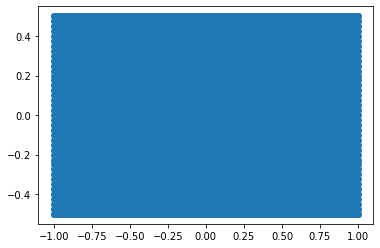

In [ ]:
x0 = df.x
y0 = df.y
z = np.ones(NN, np.float64)             #板厚t=1
show3D(x0, y0, z)

In [ ]:
Position_Node = df1.values 
print(Position_Node)

[[-0.975      -0.475     ]
 [-1.         -0.475     ]
 [-0.975      -0.49999975]
 ...
 [ 0.9625      0.49999988]
 [ 1.          0.5       ]
 [ 0.9875      0.49999988]]


In [ ]:
#Pyhton利用のため，接点番号は1-3ではなく0-2で定義する
df2 = pd.read_csv("/content/gdrive/My Drive/計算力学特論/keisan2021_inputdata.txt", sep='\s+', index_col=0, skiprows=NN+2, header=None, names=['Element_Index', 'Node_Type', 'Node0', 'Node1', 'Node2']) 
df2

,Node_Type,Node0,Node1,Node2
Element_Index,,,,
1,1,3,5,4
2,1,3,1,5
3,1,4,5,2
4,1,5,1,2
5,1,7,8,3
...,...,...,...,...
13436,1,6518,6841,6516
13437,1,6842,6840,6843
13438,1,6520,6842,6843


In [ ]:
Element = (df2.drop("Node_Type", axis=1)).values
print(Element)
print(Element[0, 2])

[[   3    5    4]
 [   3    1    5]
 [   4    5    2]
 ...
 [6520 6842 6843]
 [6518 6843 6840]
 [6520 6843 6518]]
4


In [ ]:
Position_in_Element = np.zeros((NE, 3, 2), np.float64)
for e in range(NE):
    for i in range(3):
        for d in range(2):
            Position_in_Element[e, i, d] = Position_Node[(Element[e, i]-1), d]

In [ ]:
values = {}
for e in range(NE):
    values[e] = {
        'x': {
            0: Position_in_Element[e, 0, 0],
            1: Position_in_Element[e, 1, 0],
            2: Position_in_Element[e, 2, 0]
        },
        'y': {
            0: Position_in_Element[e, 0, 1],
            1: Position_in_Element[e, 1, 1],
            2: Position_in_Element[e, 2, 1]
        }
    }
# values[e][x or y][0-2]
print(values[0])
print(values[0]['x'])

{'x': {0: -0.975, 1: -0.9875, 2: -1.0}, 'y': {0: -0.49999975000249997, 1: -0.48749987500124997, 2: -0.49999975000249997}}
{0: -0.975, 1: -0.9875, 2: -1.0}


#Calculate Volume(*e*) of each element

平面上の異なる３点(x0, y0), (x1, y1), (x2, y2)を頂点に持つ三角形の面積Area[e]
$$ Area[e] = \frac{1}{2} \left|  det\left(
    \begin{array}{ccc}
      x0 & y0 & 1 \\
      x1 & y1 & 1 \\
      x2 & y2 & 1
    \end{array}
  \right) \right| $$

$$ Area[e] = \frac{1}{2} (x1y2+ x2y0+ x0y1- x2y1- x0y2- x1y0) $$


In [ ]:
Thick = 1.0     #板厚
def Make_Volume(e):
    x0 = values[e]['x'][0]; y0 = values[e]['y'][0]  #Node0(x0, y0)
    x1 = values[e]['x'][1]; y1 = values[e]['y'][1]  #Node1(x1, y1)
    x2 = values[e]['x'][2]; y2 = values[e]['y'][2]  #Node2(x2, y2)

    Area = (1/2)* ((x1* y2)+ (x2* y0)+ (x0* y1)- (x2* y1)- (x0* y2)- (x1* y0))
    #平面上の異なる３点(x0, y0), (x1, y1), (x2, y2)を頂点に持つ三角形の面積Area[e]

    Volume = Area* Thick
    return Volume

Volume = np.zeros((NE), np.float64)
for e in range(NE):
    Volume[e] = Make_Volume(e)

#Making B_Matrix
ひずみ-変位マトリクス (Strain-displacement matrix)


\begin{align}
&\Delta=1/2\cdot[(x_k-x_j)y_i+(x_i-x_k)y_j+(x_j-x_i)y_k] \qquad \text{（要素面積）}\\
&[\boldsymbol{B}]
=\frac{1}{2\Delta}
\begin{bmatrix}
y_j-y_k & 0       & y_k-y_i & 0       & y_i-y_j & 0       \\
0       & x_k-x_j & 0       & x_i-x_k & 0       & x_j-x_i \\
x_k-x_j & y_j-y_k & x_i-x_k & y_k-y_i & x_j-x_i & y_i-y_j
\end{bmatrix}
\end{align}


In [ ]:
def Making_B_Matrix(e):
    x0 = values[e]['x'][0]; y0 = values[e]['y'][0]  #Node0(x0, y0)
    x1 = values[e]['x'][1]; y1 = values[e]['y'][1]  #Node1(x1, y1)
    x2 = values[e]['x'][2]; y2 = values[e]['y'][2]  #Node2(x2, y2)
    
    #B_Matrix作成
    B_Matrix = np.zeros((3,6),dtype=np.float64)
    Area = (1/2)* ((x2- x1)* y0+ (x0- x2)* y1+ (x1- x0)* y2)
    B_Matrix[0,0] =y1-y2; B_Matrix[0,1]=0    ; B_Matrix[0,2]=y2-y0; B_Matrix[0,3]=0    ; B_Matrix[0,4]=y0-y1; B_Matrix[0,5]=0
    B_Matrix[1,0] =0    ; B_Matrix[1,1]=x2-x1; B_Matrix[1,2]=0    ; B_Matrix[1,3]=x0-x2; B_Matrix[1,4]=0    ; B_Matrix[1,5]=x1-x0
    B_Matrix[2,0] =x2-x1; B_Matrix[2,1]=y1-y2; B_Matrix[2,2]=x0-x2; B_Matrix[2,3]=y2-y0; B_Matrix[2,4]=x1-x0; B_Matrix[2,5]=y0-y1
    B_Matrix = B_Matrix/(2/Area)
    return B_Matrix, Area

B_Matrix = np.zeros((NE, 3, 6), np.float64)
Area = np.zeros((NE), np.float64)

for e in range(NE):
    B_Matrix[e], Area[e]= Making_B_Matrix(e)

#Making D_Matrix
応力-ひずみマトリクス (Stress-strain matrix)



$${\begin{align}
\text{平面応力（nstr=1）：}& &[\boldsymbol{D_e}]=\frac{E}{1-\nu^2}\begin{bmatrix} 1 & \nu & 0 \\ \nu & 1 & 0 \\ 0 & 0 & \cfrac{1-\nu}{2} \end{bmatrix} \qquad
\begin{matrix} E & \text{：弾性係数(ヤング率)} \\ \nu & \text{：ポアソン比} \end{matrix}
\end{align}
}$$

In [ ]:
E = 0.5                     #E:ヤング率
po = 0.3                    #po:　ポアソン比

In [ ]:
def Making_D_Matrix(e):       
    #平面ひずみのD_Matrix作成
    D_Matrix=np.zeros((3,3),dtype=np.float64)
    D_Matrix[0,0]=1  ; D_Matrix[0,1]=po         #1.   po.   0
    D_Matrix[1,0]=po ; D_Matrix[1,1]=1          #po.  1.    0
    D_Matrix[2,2]=0.5*(1-po)                     #0.   0.  (1-2po)/2
    D_Matrix=E/(1-po**2)*D_Matrix
    return D_Matrix
    
D_Matrix = np.zeros((NE, 3, 3), np.float64)

for e in range(NE):
    D_Matrix[e] = Making_D_Matrix(e)

#Making Local_Matrix　
要素剛性マトリックスの作成

$${\begin{equation}
[\boldsymbol{k}]=t\cdot\int_A[\boldsymbol{B}]^T[\boldsymbol{D_e}][\boldsymbol{B}]dA=t\cdot\Delta\cdot[\boldsymbol{B}]^T[\boldsymbol{D_e}][\boldsymbol{B}]
\end{equation}
}$$

In [ ]:
def Making_Local_Matrix(e):
    #Element Stiffness matrix: [Local_Matrix]=[B_Matrix]T[D_Matrix][B_Matrix]*Thick*det(J)
    Local_Matrix = np.dot(B_Matrix[e].T, np.dot(D_Matrix[e], B_Matrix[e]))*Thick*Area[e]    #np.dot : 行列の積
    return Local_Matrix
    
Local_Matrix = np.zeros((NE, 6, 6), np.float64)
for e in range(NE):
    Local_Matrix[e] = Making_Local_Matrix(e)

#Making Global_Matrix
全体剛性マトリクスの作成

In [ ]:
Matrix_tmp = np.zeros((NE, 3, 3, 2, 2), np.float64)
for e in range(NE):
    for i in range(3):                                                                  # i : 0,1,2
        for j in range(3):                                                              # j : 0,1,2
            for dl in range(2):                                                         #dl : 0, 1
                for dm in range(2):                                                    #dm : 0,1
                    l = (2 * i + (dl +1)) -1                                                      # i, dl は０始まりなのでそれぞれ＋１，最後にLocal_Matirxも0始まりなので-1
                    m = (2 * j + (dm +1)) -1                                                   # j, dm は０始まりなのでそれぞれ＋１，最後にLocal_Matirxも0始まりなので-1
                    Matrix_tmp[e, i, j, dl, dm] = Local_Matrix[e][l][m]                      #Local_MatrixをMatrix_tmpに置き換える

Global_Matrix = np.zeros((2*NN, 2*NN), np.float64)
for e in range(NE):
    for i in range(3):
        for j in range(3):
            for dl in range(2):
                for dm in range(2):
                    L= (2* (Element[e, i]-1) + (dl +1)) -1
                    M= (2* (Element[e, j]-1)+ (dm +1)) -1
                    Global_Matrix[L][M] = Global_Matrix[L][M] + Matrix_tmp[e, i, j, dl, dm]                      #全体剛性マトリクスK[L, M]を求める

In [ ]:
print(Global_Matrix)

[[ 9.41535356e-16 -1.06432608e-21 -1.06433632e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.06432608e-21  1.04797329e-15 -1.63744930e-22 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.06433632e-16 -1.63744930e-22  4.42112459e-16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.63744112e-31
  -1.06432608e-36 -1.63744112e-31]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.06432608e-36
   2.29241757e-31  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.63744112e-31
   0.00000000e+00  6.54976447e-31]]


#Making Edge Data


In [ ]:
Number_Xmin = []
Number_Xmax = []
X_min = 0
X_max = 0
IG = 0
IH = 0

for N in range(NN):
    if (Position_Node[N][0] < X_min):
        X_min = Position_Node[N][0]

    if (Position_Node[N][0] > X_max):
        X_max = Position_Node[N][0]

    if (Position_Node[N][0] == X_min):
        Number_Xmin.append(N)
        IG = IG+ 1

    if (Position_Node[N][0] == X_min):
        Number_Xmax.append(N)
        IH = IH+ 1

print(IG)
print(IH)
print(Number_Xmax)

44
44
[0, 1, 3, 243, 404, 565, 726, 887, 1048, 1209, 1370, 1531, 1692, 1853, 2014, 2175, 2336, 2497, 2658, 2819, 2980, 3141, 3302, 3463, 3624, 3785, 3946, 4107, 4268, 4429, 4590, 4751, 4912, 5073, 5234, 5395, 5556, 5717, 5878, 6039, 6200, 6361, 6521, 6683]


In [ ]:
# #mpfix =各接点毎の拘束条件を格納した配列（＝１：拘束，　＝０：自由）， fp=接点荷重ベクトル， rdis=変位拘束する節点の変位量， disg=全体剛性方程式の解（変位）
# # treatment of boundary conditions
#     for i in range(0,NE):
#         for j in range(0,2):
#             if mpfix[j,i]==1:
#                 iz=i*2+j
#                 fp[iz]=0.0
#     for i in range(0,NE):
#         for j in range(0,2):
#             if mpfix[j,i]==1:
#                 iz=i*2+j
#                 fp=fp-rdis[j,i]*Global_Matrix[:,iz]
#                 Global_Matrix[:,iz]=0.0
#                 Global_Matrix[iz,iz]=1.0
#     # solution of simultaneous linear equations
#     #disg = np.linalg.solve(Global_Matrix, fp)
#     Global_Matrix = csr_matrix(Global_Matrix)
#     disg = spsolve(Global_Matrix, fp, use_umfpack=True)
#     # recovery of restricted displacements
#     for i in range(0,NE):
#         for j in range(0,NE):
#             if mpfix[j,i]==1:
#                 iz=i*NE+j
#                 disg[iz]=rdis[j,i]

In [ ]:
# # treatment of boundary conditions
#     for i in range(0,NE):
#         for j in range(0,2):
#             if mpfix[j,i]==1:
#                 iz=i*2+j
#                 fp[iz]=0.0
#     for i in range(0,NE):
#         for j in range(0,2):
#             if mpfix[j,i]==1:
#                 iz=i*2+j
#                 fp=fp-rdis[j,i]*Global_Matrix[:,iz]
#                 Global_Matrix[:,iz]=0.0
#                 Global_Matrix[iz,iz]=1.0
#     # solution of simultaneous linear equations
#     #disg = np.linalg.solve(Global_Matrix, fp)
#     Global_Matrix = csr_matrix(Global_Matrix)
#     disg = spsolve(Global_Matrix, fp, use_umfpack=True)
#     # recovery of restricted displacements
#     for i in range(0,NE):
#         for j in range(0,2):
#             if mpfix[j,i]==1:
#                 iz=i*2+j
#                 disg[iz]=rdis[j,i]

#Make Force


In [ ]:
Force = np.zeros((2*NN), np.float64)
Load = 0.001

for I in range(IH-1):
    for J in range((2*NN)-1):
        if (J == 2*Number_Xmax[I]):
            Force[J] = -Load

#Setting dirichilet boundary
ディレクリ境界条件の実装

In [ ]:
for I in range(IG):
    for J in range(2*NN):
        if (J == (2*Number_Xmin[I])):
            Global_Matrix[2*Number_Xmin[I]][J] = 1
        else:
            Global_Matrix[2*Number_Xmin[I]][J] = 0
            Global_Matrix[J][2*Number_Xmin[I]] = 0

        if (J == 2*Number_Xmin):
            Global_Matrix[2*Number_Xmin[I]+1][J] = 1
        else:
            Global_Matrix[2*Number_Xmin[I]+1][J] = 0
            Global_Matrix[J][2*Number_Xmin[I]+1] = 0

#Calculating Simultaneous equation
連立方程式を解く

In [ ]:
Solution = []
# Solution = np.zeros((NN, NN), np.float64)

Ainv = np.linalg.pinv(Global_Matrix)
disg = np.dot(Ainv, Force)

# info = dgesv (2*NN, Global_Matrix, ipiv, Force)
for n in range(NN):
    Solution.append([Position_Node[n][0] + Force[2*n], Position_Node[n][1]+ Force[2*n+1]])

NameError: ignored

#Result Visuallization

In [ ]:
show3D(x0, y0, z)

#実行コード

## Initial Setting

In [ ]:
# Initial_Setting()
#Initial_Setting(nstr, E, Po, BC_left, BC_right, BC_upper, BC_lower,  )
    #nstr=0:平面ひずみ（要素板厚t=1とする）
    #nstr=1:平面応力
    #E:ヤング率
    #Po:ポアソン比
    #BC_　:Boundary Condition of each egde 各端の境界条件
